### Content Analysis
#### Joseph Denby

Load relevant packages and functions. 

In [1]:
import pandas as pd
import numpy as np
import random
import math

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy
from scipy import stats
import lucem_illud
import lucem_illud.stanford as stanford

import nltk
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
%matplotlib inline

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


In [2]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

In [3]:
def wordsample(tokens, n):
    '''
    takes a list of tokens (or sentences) and an amount (n) and returns a random sample
    
    Inputs:
        tokens - list of tokenized text
        n - int
    
    Outputs:
        sample - contiguous n sample from tokens
    '''
    
    if len(tokens) <= n:
        sample = tokens
    else:
        startindex = random.randint(1, len(tokens)-n)
        sample = tokens[startindex : startindex+n]
    
    return sample

In [4]:
def POSdict(tokens_POS):
    '''
    takes a list of tuples indicating POS taggings for tokenized words and returns 
    a dictionary counting up the POS tag instances
    
    Inputs:
        tokens_POS - list of tuples
        
    Outputs:
        POSdict - dictionary
    '''
    POSdict = {}
    for t in tokens_POS:
        word, tag = t
        if tag not in ['.', ',', "''", '#', '?', '!', ':', '(', ')', '$', '"', '``']:
            if tag not in POSdict:
                POSdict[tag] = 0
            POSdict[tag] += 1
    
    return POSdict

In [5]:
def getavgPOSdict(POSdictseries):
    '''
    takes a series of POSdicts and returns a dictionary with the average POS counts 
    
    Inputs:
        POSdictseries - series of POSdicts
        
    Outputs:
        avgPOSdict - dictionary
    '''
    
    avgPOSdict = {}
    total = len(POSdictseries)
    
    for d in POSdictseries:
        for k, v in d.items():
            if k not in avgPOSdict:
                avgPOSdict[k] = 0
            avgPOSdict[k] += v/total
    
    return avgPOSdict
    

In [6]:
def averageSampleCounts(dataframe, n):
    '''
    Takes a DataFrame and returns a dictionary
    with the counts for each POS found in a random contiguous n word sample.
    
    Inputs:
        dataframe - DataFrame
    
    Outputs:
        avgPOSdict - dictionary 
    
    '''
    tag = str(n) + 'wordsample'
    
    dataframe[tag] = dataframe['tokens'].apply(lambda x: wordsample(x, n))
    dataframe['tokens_POS'] = [nltk.pos_tag(t) for t in dataframe[tag]]
    
    dataframe['POSdict'] = dataframe['tokens_POS'].apply(lambda x: POSdict(x))
    avgPOSdict = getavgPOSdict(dataframe['POSdict'])
    
    return avgPOSdict
    
    

In [7]:
def getPOSdf(chatavgavgPOSdict, bookavgavgPOSdict):
    '''
    Takes two dictionaries with the average average POS counts and converts them into a single melted DataFrame,
    primed for plotting.
    
    Inputs:
        chatavgavgPOSdict - dictionary
        bookavgavgPOSdict - dictionary
    Output:
        compareavgPOSdf - DataFrame
    '''
    
    chatavgPOSdf = pd.DataFrame.from_dict(chatavgavgPOSdict, orient = 'index')
    bookavgPOSdf = pd.DataFrame.from_dict(bookavgavgPOSdict, orient = 'index')
    
    chatavgPOSdf = chatavgPOSdf.reset_index()
    bookavgPOSdf = bookavgPOSdf.reset_index()
    
    chatavgPOSdf = chatavgPOSdf.rename(columns = {'index': 'POS', 0: 'chat'})
    bookavgPOSdf = bookavgPOSdf.rename(columns = {'index': 'POS', 0: 'book'})
    
    compareavgPOSdf = bookavgPOSdf.merge(chatavgPOSdf, how='left', on='POS',)
    compareavgPOSdf['abs_diff'] = compareavgPOSdf.apply(lambda x: x['book'] - x['chat'], axis=1)
    compareavgPOSdf = compareavgPOSdf.sort_values('abs_diff', ascending=False)
    compareavgPOSdf = compareavgPOSdf.reset_index(drop=True)
    compareavgPOSdf = compareavgPOSdf.melt(id_vars=['POS'], value_vars=['book', 'chat'], var_name='source', value_name='avgcount')
    
    return compareavgPOSdf

In [8]:
def getPOSsterrs(avgPOSdicts):
    POSsterrs = {}
    for d in avgPOSdicts:
        for k, v in d.items():
            if k not in POSsterrs:
                POSsterrs[k] = []
            POSsterrs[k].append(v)
                    
    for k, v in POSsterrs.items():
        POSsterrs[k] = np.array(v)
        POSsterrs[k] = np.std(v)/np.sqrt(len(POSsterrs[k]))
    return POSsterrs

In [9]:
def makePOScountsdf(POSdicts):
    '''
    Takes list/series of POS dictionaries and creates a dataframe with the counts for each POS tag.
    '''
    POSdicts = POSdicts.tolist()
    firstdic = POSdicts.pop()
    POScountsdf = pd.DataFrame.from_dict(firstdic,orient='index')
    
    for d in POSdicts:
        initdf = pd.DataFrame.from_dict(d,orient='index')
        POScountsdf = POScountsdf.merge(initdf, how='left', left_index=True, right_index=True)
    
    return POScountsdf

In [10]:
def avgwordsample(tokens, wordn, samplen):
    '''
    Takes a list of tokens and returns an dictionary of POS counts for a wordn random sample conducted samplen times.
    
    Outputs:
        avgPOSdict 
    '''
    sampledictlist = []
    
    for _ in range(samplen):
        sample = wordsample(tokens, wordn)
        samplePOS = nltk.pos_tag(sample)
        sampledict = POSdict(samplePOS)
        sampledictlist.append(sampledict)
    
    avgPOSdict = getavgPOSdict(sampledictlist)
    
    return avgPOSdict

In [11]:
def sent_complexity(sents):
    '''
    Takes a list of lists (sentences) with tokenized words and returns a list of each sentence's depth 
    when represented as a parsed tree
    
    Inputs:
        sents (list of lists)
    Outputs:
        sentheights (list)
    '''

    parses = list(stanford.parser.parse_sents(sents))
    sentheights = []
    for s in parses:
        sentheights.append(list(s)[0].height())
    
    return sentheights

In [12]:
def avg_sent_complexity(sents, sentn, samplen):
    '''
    Takes a list of sentences with tokenized words, takes a sample of those sentences with size sentn, and,
    on that sample, compute each sentence's depth when represented as a parse tree. Repeats this process samplen
    times and returns an average average parse tree depth.
    
    Inputs:
        sents (list of lists)
        sentn (int)
        samplen (int)
    Outputs:
        allavg_sentheights (list)
        allsd_sentheights (list)
    '''
    allavg_sentheights = []
    allsd_sentheights = []
    
    for _ in range(samplen):
        sample = wordsample(sents, sentn)
        sentheights = sent_complexity(sample)
        avg_sentheights = np.mean(sentheights)
        sd_sentheights = np.std(sentheights)
        allavg_sentheights.append(avg_sentheights)
        allsd_sentheights.append(sd_sentheights)
    
    return allavg_sentheights, allsd_sentheights
        
        

TODO
- Organize by difference between counts. __[DONE]__
- Look at change over time (based on session or suggested grade/age level for books) __[DONE]__
- look at distribution of speech (variability, not just means) and plot alongside books __[DONE]__
- Try parsing - look at tree depth over book sentences. (*some measure of complexity*) __[DONE]__
- ANOVA for comparing differences (filter out variance due to individual differences)
- kids POS productions/sentence complexity over time
- compare with adult conversation corpus (Santa Barbara?) and adult book text
- Lexile measure for books?
- Examine differences in trajectory for chat by SES
- Investigate word specificity / concreteness with WordNet
- Oxford Children's Corpus (look at writing *by* children)

Read in dataframes:

### Parent & Child CHAT DATAFRAMES

In [103]:
utterances = pd.read_csv('utterances.csv', index_col=0)
utterances.fillna(value = {'p_chat':'', 'c_chat':''}, inplace=True)

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [104]:
utterances['p_chat'] = utterances['p_chat'].apply(lambda x: x + ' ')
utterances['c_chat'] = utterances['c_chat'].apply(lambda x: x + ' ')

In [105]:
p_chats = utterances.groupby(['subject', 'session'])['p_chat'].sum().reset_index()
c_chats = utterances.groupby(['subject', 'session'])['c_chat'].sum().reset_index()

In [106]:
p_chats['sents'] = p_chats['p_chat'].apply(lambda x: nltk.sent_tokenize(x))
p_chats['sent_tokens'] = p_chats['sents'].apply(lambda v: [nltk.wordpunct_tokenize(s) for s in v])

In [17]:
c_chats['sents'] = c_chats['c_chat'].apply(lambda x: nltk.sent_tokenize(x))
c_chats['sent_tokens'] = c_chats['sents'].apply(lambda v: [nltk.wordpunct_tokenize(s) for s in v])

Clean out sessions where parents/children talk very little (too small samples):

In [107]:
lowsentcounts = []
for i, s in enumerate(p_chats['sents']):
    if len(s) < 50 or not s:
        lowsentcounts.append(i)
for i in lowsentcounts:
    p_chats.drop(i, inplace=True)
p_chats.reset_index(inplace=True, drop=True)

In [19]:
lowsentcounts = []
for i, s in enumerate(c_chats['sents']):
    if len(s) < 10 or not s:
        lowsentcounts.append(i)
for i in lowsentcounts:
    c_chats.drop(i, inplace=True)
c_chats.reset_index(inplace=True, drop=True)

In [108]:
p_chats['tokens'] = p_chats.p_chat.apply(lambda x: nltk.wordpunct_tokenize(x))
p_chats['word_count'] = p_chats.tokens.apply(lambda x: len(x))

### BOOK DATAFRAME

In [ ]:
bookdf = pd.read_csv("bookdf.csv", index_col=0)

## 
bookdf = bookdf.drop(15) #to get rid of 'Goodnight Moon' which has less than 100 words
bookdf = bookdf.drop(74) #drop 'Chicka Chicka 1-2-3' because the parser has trouble with it (numbers?)
bookdf = bookdf.reset_index(drop=True)
##

bookdf['tokens'] = bookdf['text'].apply(lambda x: nltk.wordpunct_tokenize(x))
bookdf['sents'] = bookdf['text'].apply(lambda x: nltk.sent_tokenize(x))
bookdf['sent_tokens'] = bookdf['sents'].apply(lambda v: [nltk.wordpunct_tokenize(s) for s in v])
#bookdf['nltktext'] = bookdf['tokens'].apply(lambda x: nltk.Text(x))
bookdf['word_count'] = bookdf.tokens.apply(lambda x: len(x))
#bookdf['wordsample100'] = bookdf.tokens.apply(lambda x: wordsample100(x))


### Procedure for Computing and Plotting Sentence Complexities

In [23]:
#VERY SLOW
#p_chats['sent_complexities'] = p_chats['sent_tokens'].apply(lambda x: sent_complexity(wordsample(x, 90)))
#p_chats['avg_sent_complex'] = p_chats['sent_complexities'].apply(lambda x: np.mean(x))
#p_chats['sd_sent_complex'] = p_chats['sent_complexities'].apply(lambda x: np.std(x))

In [26]:
p_complex_df = pd.read_csv('p_complexity_data.csv', index_col=0)
p_complex_df['book'] = False

In [27]:
p_complex_df.head()

,subject,session,sent_complexities,avg_sent_complex,sd_sent_complex,book
0,22,1,"[5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 8, 5, ...",6.677778,1.942666,False
1,22,2,"[7, 6, 6, 5, 6, 6, 5, 6, 4, 4, 6, 10, 5, 5, 10...",6.322222,1.678808,False
2,22,3,"[5, 11, 5, 5, 7, 11, 5, 4, 6, 6, 7, 5, 11, 6, ...",6.688889,2.009115,False
3,22,4,"[5, 9, 4, 8, 6, 4, 6, 9, 11, 6, 5, 7, 4, 7, 11...",6.433333,1.751507,False
4,22,5,"[5, 6, 6, 6, 5, 6, 12, 9, 6, 5, 5, 8, 5, 5, 8,...",7.400000,2.462158,False


In [51]:
book_complex_df = pd.read_csv('book_complexity_data.csv', index_col=0)
book_complex_df['book'] = True
book_complex_df['session'] = 'book'
book_complex_df.rename(columns={'sent_complexity':'sent_complexities','stdev_sent_complex':'sd_sent_complex'},inplace=True)

In [31]:
book_complex_df.head()

,author,title,sent_complexities,avg_sent_complex,sd_sent_complex,book,session
0,Jules Feiffer,"Bark, George","[11, 7, 9, 6, 6, 5, 9, 9, 8, 5, 7, 9, 6, 6, 5,...",6.500000,2.299068,True,13
1,Robert McCloskey,Blueberries for Sal,"[9, 10, 8, 10, 8, 4, 4, 6, 7, 8, 5, 9, 11, 9, ...",9.950617,3.295718,True,13
2,Bill Martin Jr,"Brown Bear, Brown Bear, What Do You See?","[11, 9, 11, 9, 11, 9, 11, 9, 11, 9, 11, 9, 11,...",9.739130,1.187522,True,13
3,Doreen Cronin,"Click, Clack, Moo Cows that Type","[6, 7, 7, 5, 5, 9, 5, 5, 5, 5, 5, 9, 8, 8, 14,...",6.761905,1.831941,True,13
4,Judi Barrett,Cloudy With a Chance of Meatballs,"[8, 6, 6, 9, 14, 7, 10, 4, 4, 7, 11, 6, 7, 12,...",8.756757,2.835477,True,13


In [78]:
complex_df = p_complex_df.drop(columns=['subject']).append(book_complex_df.drop(columns=['author','title']))
complex_df.reset_index(inplace=True, drop=True)

In [80]:
regplot_df = complex_df[complex_df['session']!='book']
regplot_df['session'] = regplot_df['session'].apply(lambda x: int(x))

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


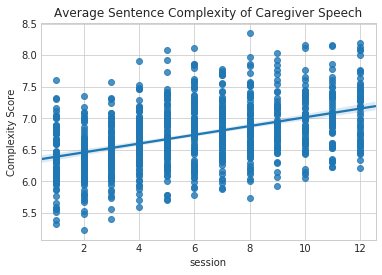

In [100]:
g = sns.regplot(x = 'session', y = 'avg_sent_complex', data = regplot_df)
g.set_title('Average Sentence Complexity of Caregiver Speech');
g.set_ylabel('Complexity Score');
#plt.savefig('p_complex.png',bbox_inches='tight')

/home/jgdenby/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


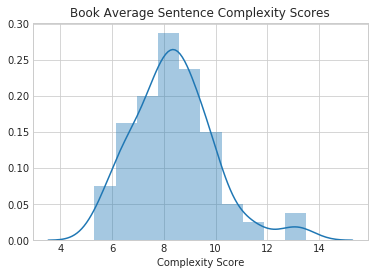

In [93]:
g = sns.distplot(complex_df[complex_df['session']=='book']['avg_sent_complex'])
g.set_title('Book Average Sentence Complexity Scores');
g.set_xlabel('Complexity Score');

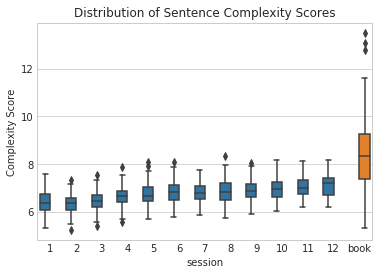

In [101]:
sns.set_style('whitegrid')
g = sns.boxplot(x='session', y = 'avg_sent_complex', hue = 'book', data=complex_df)
g.legend_.remove()
g.set_title('Distribution of Sentence Complexity Scores');
g = g.set_ylabel('Complexity Score')
#plt.savefig('p&b_complex.png',bbox_inches = 'tight')

### Procedure for Computing and Plotting Average 150 Word POS Counts

#### For Speech

In [ ]:
#set word sample size
n = 150

In [110]:
#SLOW - creates a dictionary for each conversation of the POS count for the average n word sample
p_chats['avg150wordPOScount'] = p_chats['tokens'].apply(lambda x:avgwordsample(x, n, 50))

In [113]:
sessionPOSdicts = p_chats.groupby('session').avg150wordPOScount.apply(list)

In [114]:
sessionPOSdicts = sessionPOSdicts.to_frame()

In [116]:
#collapses sessions across people
sessionPOSdicts['avgPOS'] = sessionPOSdicts['avg150wordPOScount'].apply(lambda x: getavgPOSdict(x))

In [117]:
sessionPOSdicts.head()

,avg150wordPOScount,avgPOS
session,,
1,"[{'VBN': 0.9600000000000004, 'NNP': 7.35999999...","{'VBN': 0.6755844155844157, 'NNP': 4.978181818..."
2,"[{'PRP': 13.740000000000002, 'VBP': 6.78000000...","{'PRP': 12.9725, 'VBP': 5.5207500000000005, 'D..."
3,"[{'WP': 6.479999999999999, 'VBP': 6.8200000000...","{'WP': 2.240000000000001, 'VBP': 5.95686746987..."
4,"[{'JJ': 7.8599999999999985, 'NN': 20.180000000...","{'JJ': 6.546904761904764, 'NN': 19.09857142857..."
5,"[{'VB': 7.119999999999999, 'NN': 19.12, 'RB': ...","{'VB': 10.68, 'NN': 18.598139534883728, 'RB': ..."


Creates DataFrame and plots with POS counts for each 150 word sample taken from each session.

In [122]:
sessioncountsdf = pd.DataFrame()
for i, r in sessionPOSdicts.iterrows():
    for d in r['avg150wordPOScount']:
        sessiondf = pd.DataFrame.from_dict(d, orient = 'index')
        sessiondf['session'] = i
        sessioncountsdf = sessioncountsdf.append(sessiondf)
sessioncountsdf.reset_index(inplace = True)
sessioncountsdf = sessioncountsdf.rename(columns = {'index':'POS', 0:'count'})
sessioncountsdf['book'] = False
sessioncountsdf = sessioncountsdf[sessioncountsdf['POS'] != 'SYM']

In [123]:
sessioncountsdf.head()

,POS,count,session,book
0,VBN,0.96,1,False
1,NNP,7.36,1,False
2,DT,8.52,1,False
3,NN,17.06,1,False
4,IN,8.34,1,False


Text(0.5,0.98,'Distribution of Speech POS Counts by Session')

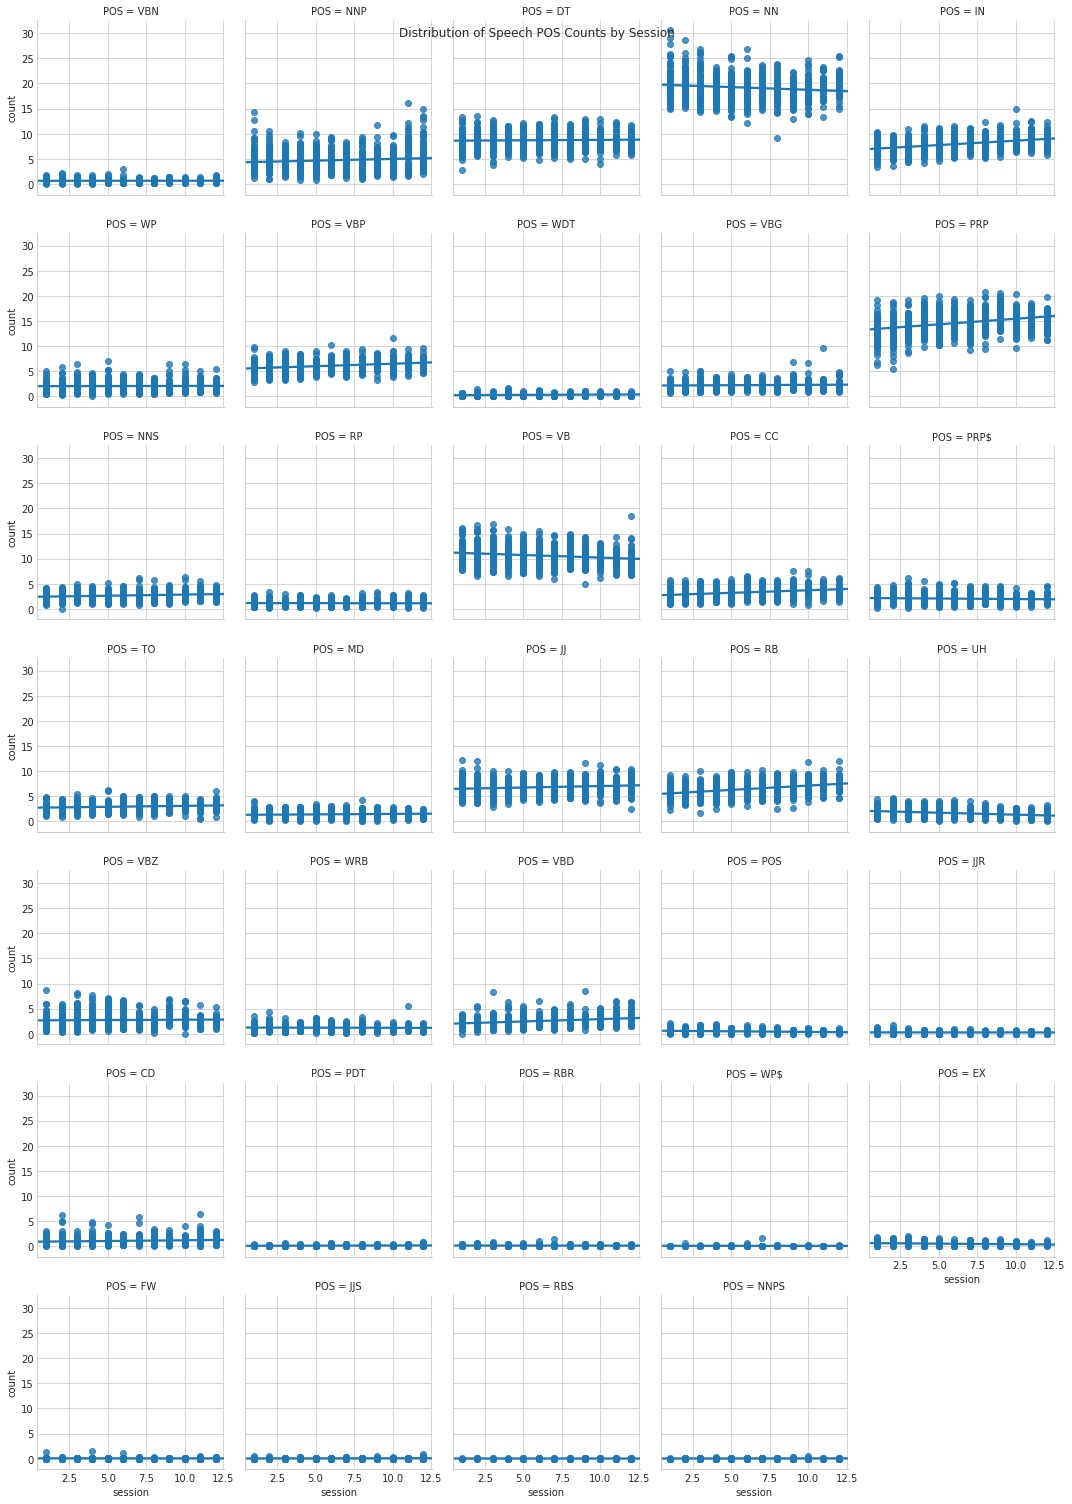

In [125]:
g = sns.FacetGrid(sessioncountsdf, col = 'POS', col_wrap=5)
g.map(sns.regplot, "session", "count")
g.fig.suptitle('Distribution of Speech POS Counts by Session');

#### For Books

In [126]:
bookdf['avg150wordPOScount'] = bookdf['tokens'].apply(lambda x:avgwordsample(x, 150, 50))

In [127]:
bookcountsdf = pd.DataFrame()
for i, r in bookdf.iterrows():
    bookPOSdf = pd.DataFrame.from_dict(r['avg150wordPOScount'], orient = 'index')
    bookPOSdf.reset_index(inplace=True)
    bookcountsdf = bookPOSdf.append(bookcountsdf)
    bookcountsdf.reset_index(inplace =True, drop=True)

bookcountsdf = bookcountsdf.rename(columns = {'index':'POS', 0:'count'})

In [128]:
bookcountsdf['session'] = 13
bookcountsdf['book'] = True

In [131]:
# for every book, a POS count for its average 150 word count
bookcountsdf.head()

,POS,count,session,book
0,IN,14.26,13,True
1,PRP$,1.64,13,True
2,NNS,16.38,13,True
3,VBP,4.20,13,True
4,RP,1.60,13,True


In [42]:
booksessioncountsdf = sessioncountsdf.append(bookcountsdf)
booksessioncountsdf.reset_index(inplace=True, drop=True)

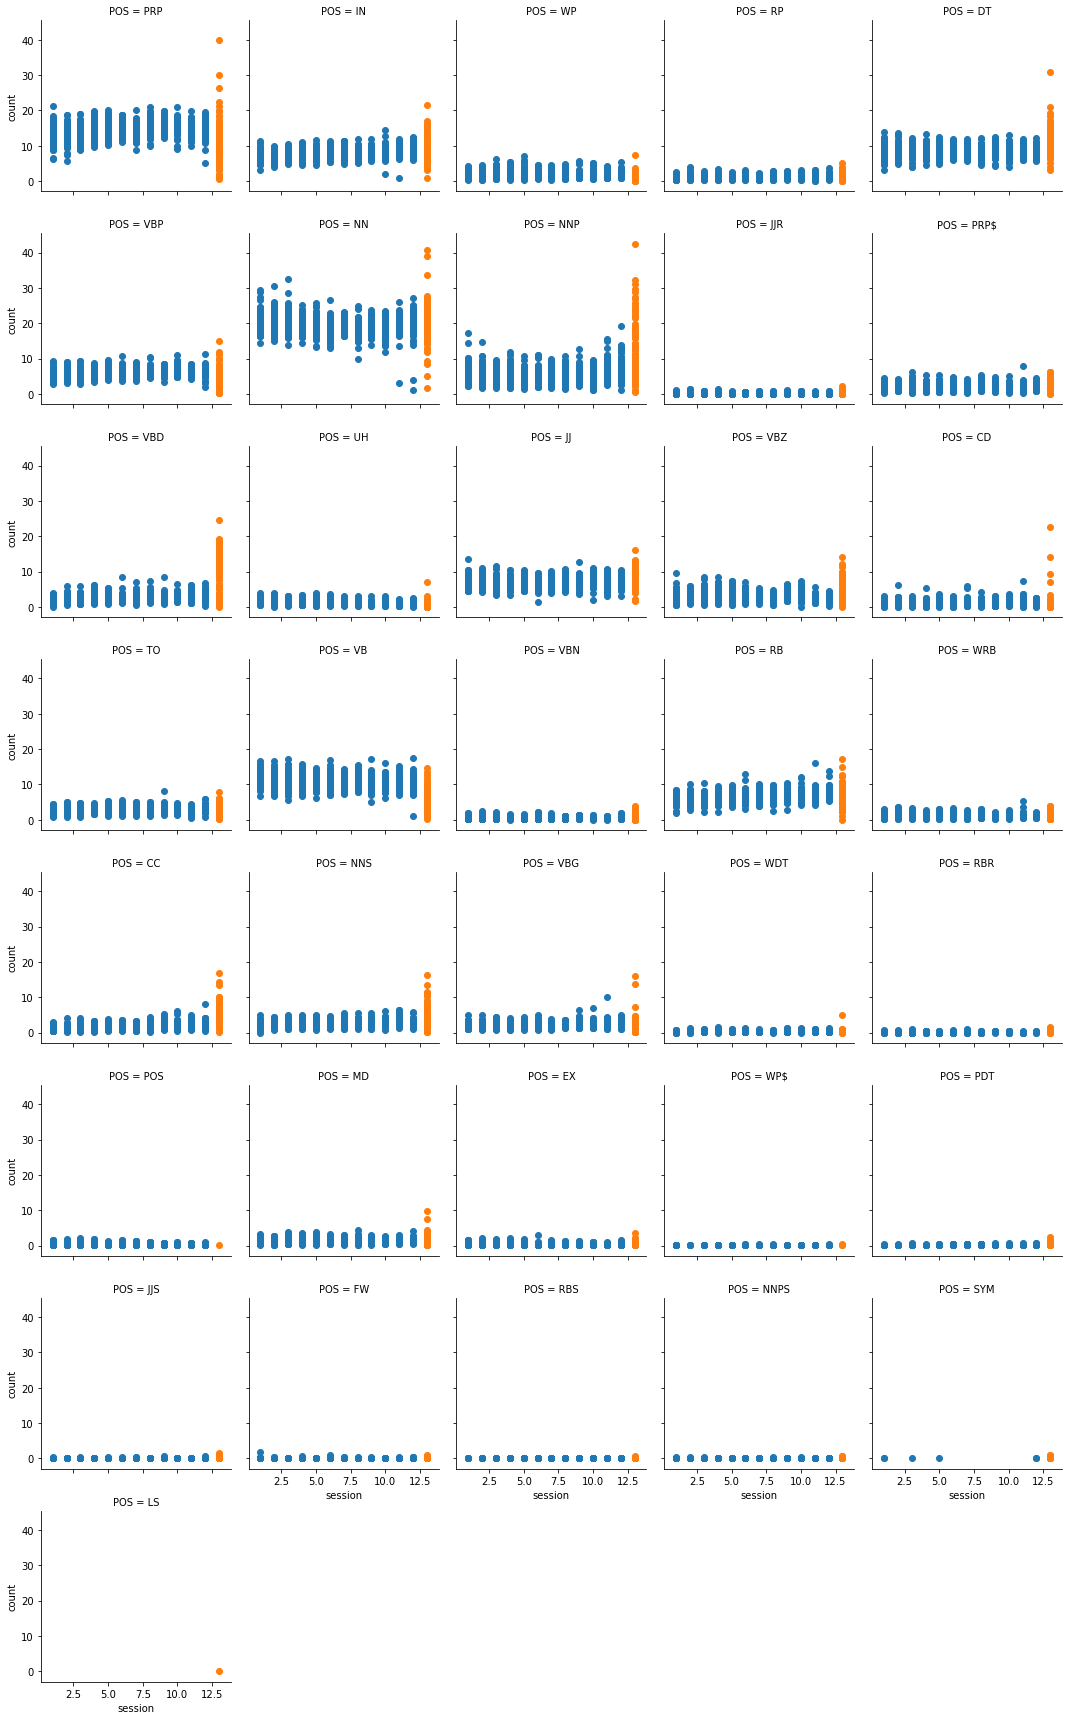

In [47]:
g = sns.FacetGrid(booksessioncountsdf, col = 'POS', hue='book', col_wrap=5)
g.map(plt.scatter, "session", "count")

Creates DataFrame and plots with the average POS counts for 150 word samples by each session.

In [228]:
sessionavgcountsdf = pd.DataFrame()
for i, r in sessionPOSdicts.iterrows():
    sessiondf = pd.DataFrame.from_dict(r['avgPOS'], orient = 'index')
    sessiondf.reset_index(inplace=True)
    sessiondf['session'] = i
    sessionavgcountsdf = sessionavgcountsdf.append(sessiondf)
    sessionavgcountsdf.reset_index(inplace =True, drop=True)

sessionavgcountsdf = sessionavgcountsdf.rename(columns = {'index':'POS', 0:'count'})

In [229]:
sessionavgcountsdf.head()

,POS,count,session
0,PRP,13.156104,1
1,JJ,7.433506,1
2,VBZ,2.435325,1
3,VBP,5.691429,1
4,VBG,2.257662,1


In [230]:
bookavgavgPOSdict = getavgPOSdict(bookavgPOSdicts)

In [234]:
bookavgavgPOSdf = pd.DataFrame.from_dict(bookavgavgPOSdict, orient = 'index')
bookavgavgPOSdf.reset_index(inplace=True)
bookavgavgPOSdf['session'] = 13 #stipulate books as their own session for plotting purposes
bookavgavgPOSdf['book'] = True
bookavgavgPOSdf = bookavgavgPOSdf.rename(columns = {'index':'POS', 0:'count'})
sessionavgcountsdf['book'] = False
booksessionavgcountsdf = sessionavgcountsdf.append(bookavgavgPOSdf)


In [236]:
booksessionavgcountsdf.head()

,POS,count,session,book
0,PRP,13.156104,1,False
1,JJ,7.433506,1,False
2,VBZ,2.435325,1,False
3,VBP,5.691429,1,False
4,VBG,2.257662,1,False


In [243]:
booksessionavgcountsdf.to_csv('avgPOScounts.csv')

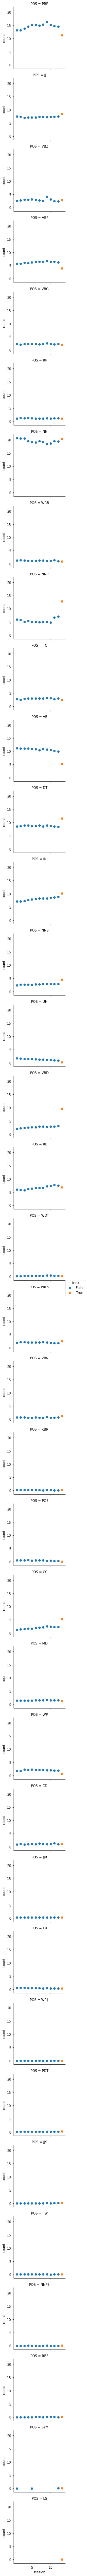

In [241]:
g = sns.FacetGrid(booksessionavgcountsdf, row = 'POS', hue='book')
g = g.map(plt.scatter, 'session', 'count')
g.add_legend()

In [22]:
chatavgPOSdicts = []
for i in range(100):
    if i % 10 == 0:
        print(i)
    dikt = averageSampleCounts(ldpdf, n)
    chatavgPOSdicts.append(dikt)

#chatavgavgPOSdict = getavgPOSdict(chatavgPOSdicts)

0


KeyboardInterrupt: 

In [152]:
chatPOSsterrs = {}
for d in chatavgPOSdicts:
    for k, v in d.items():
        if k not in chatPOSsterrs:
            chatPOSsterrs[k] = []
        chatPOSsterrs[k].append(v)
for k, v in chatPOSsterrs.items():
    chatPOSsterrs[k] = np.array(v)
    chatPOSsterrs[k] = np.std(v)/np.sqrt(len(chatPOSsterrs[k]))

In [158]:
chatPOSsterrs = getPOSsterrs(chatavgPOSdicts)

In [123]:
chatavgavgPOSdict = getavgPOSdict(chatavgPOSdicts)

### BOOK DATAFRAME

In [16]:
bookdf['sent_complexity'] = bookdf['sent_tokens'].apply(lambda x: sent_complexity(x))

In [17]:
bookdf['avg_sent_complex'] = bookdf['sent_complexity'].apply(lambda x: np.mean(x))
bookdf['stdev_sent_complex'] = bookdf['sent_complexity'].apply(lambda x: np.std(x))

In [18]:
bookdf.head()

,author,text,title,tokens,sents,sent_tokens,word_count,sent_complexity,avg_sent_complex,stdev_sent_complex
0,Jules Feiffer,"George’s mother said: ""Bark, George."" George w...","Bark, George","[George, ’, s, mother, said, :, "", Bark, ,, Ge...","[George’s mother said: ""Bark, George."", George...","[[George, ’, s, mother, said, :, "", Bark, ,, G...",364,"[11, 7, 9, 6, 6, 5, 9, 9, 8, 5, 7, 9, 6, 6, 5,...",6.500000,2.299068
1,Robert McCloskey,"One day, Little Sal went with her mother to Bl...",Blueberries for Sal,"[One, day, ,, Little, Sal, went, with, her, mo...","[One day, Little Sal went with her mother to B...","[[One, day, ,, Little, Sal, went, with, her, m...",1253,"[9, 10, 8, 10, 8, 4, 4, 6, 7, 8, 5, 9, 11, 9, ...",9.950617,3.295718
2,Bill Martin Jr,"Brown Bear, Brown Bear, What do you see? I see...","Brown Bear, Brown Bear, What Do You See?","[Brown, Bear, ,, Brown, Bear, ,, What, do, you...","[Brown Bear, Brown Bear, What do you see?, I s...","[[Brown, Bear, ,, Brown, Bear, ,, What, do, yo...",251,"[11, 9, 11, 9, 11, 9, 11, 9, 11, 9, 11, 9, 11,...",9.739130,1.187522
3,Doreen Cronin,Farmer Brown has a problem. His cows like to t...,"Click, Clack, Moo Cows that Type","[Farmer, Brown, has, a, problem, ., His, cows,...","[Farmer Brown has a problem., His cows like to...","[[Farmer, Brown, has, a, problem, .], [His, co...",541,"[6, 7, 7, 5, 5, 9, 5, 5, 5, 5, 5, 9, 8, 8, 14,...",6.761905,1.831941
4,Judi Barrett,We were all sitting around the big kitchen tab...,Cloudy With a Chance of Meatballs,"[We, were, all, sitting, around, the, big, kit...",[We were all sitting around the big kitchen ta...,"[[We, were, all, sitting, around, the, big, ki...",1423,"[8, 6, 6, 9, 14, 7, 10, 4, 4, 7, 11, 6, 7, 12,...",8.756757,2.835477


In [49]:
bookdf['avg150wordPOScount'] = bookdf['tokens'].apply(lambda x:avgwordsample(x, 150, 50))

Creates DataFrame and plot of POS counts for each book's average 150 word sample.

In [29]:
bookcountsdf = pd.DataFrame()
for i, r in bookdf.iterrows():
    bookPOSdf = pd.DataFrame.from_dict(r['avg150wordPOScount'], orient = 'index')
    bookPOSdf.reset_index(inplace=True)
    bookcountsdf = bookPOSdf.append(bookcountsdf)
    bookcountsdf.reset_index(inplace =True, drop=True)

bookcountsdf = bookcountsdf.rename(columns = {'index':'POS', 0:'count'})

In [30]:
bookcountsdf.head()

,POS,count
0,NNS,16.26
1,VBP,4.60
2,TO,1.64
3,NN,24.28
4,CC,6.38


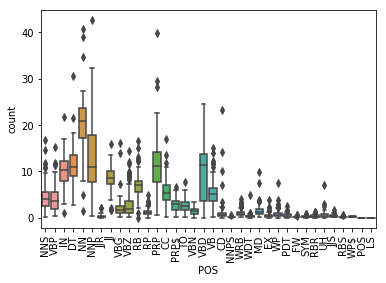

In [211]:
g = sns.boxplot(x = 'POS', y='count', data=bookcountsdf)
#axes = g.axes.flatten()
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [16]:
bookavgPOSdicts = []
for i in range(100): #takes a few minutes
    if i % 10 == 0:
        print (i)
    dikt = averageSampleCounts(bookdf, n)
    bookavgPOSdicts.append(dikt)

0
10
20
30
40
50
60
70
80
90


In [214]:
bookavgavgPOSdict = getavgPOSdict(bookavgPOSdicts)

In [31]:
bookPOScountdf = pd.DataFrame.from_dict(bookavgPOSdicts[0],orient='index')

In [39]:
firstdic = bookdf.POSdict.tolist().pop()

In [40]:
firstdic

{'CC': 7,
 'DT': 13,
 'IN': 15,
 'JJ': 6,
 'NN': 27,
 'NNP': 7,
 'NNS': 20,
 'PRP': 2,
 'PRP$': 3,
 'RB': 2,
 'RP': 2,
 'TO': 4,
 'VB': 1,
 'VBD': 2,
 'VBG': 2,
 'VBN': 3,
 'VBP': 5,
 'VBZ': 3}

In [42]:
bookPOScountsdf = makePOScountsdf(bookdf.POSdict)

In [213]:
compareavgPOSdf = getPOSdf(chatavgavgPOSdict, bookavgavgPOSdict)

NameError: name 'chatavgavgPOSdict' is not defined

In [212]:
compareavgPOSdf

NameError: name 'compareavgPOSdf' is not defined

The following plot shows the average POS counts for word samples from both corpora.

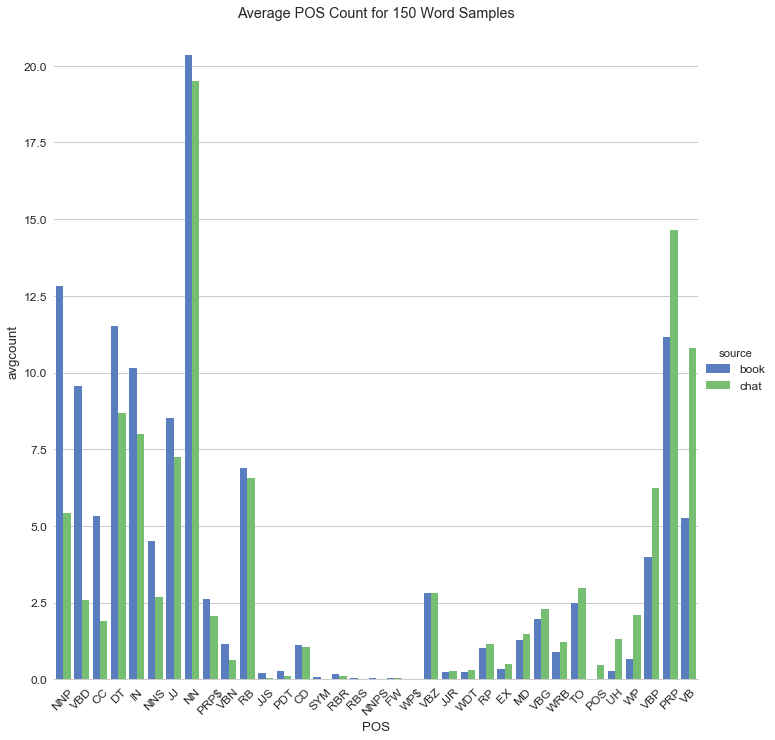

In [200]:
sns.set(font_scale=1.2, style='whitegrid')

g = sns.factorplot(x = 'POS', y = 'avgcount', hue='source', data=compareavgPOSdf, size=10, kind='bar', palette='muted')
g.despine(left = True)
g.set_xticklabels(rotation=45)
axes = g.axes.flatten()
axes[0].set_title('Average POS Count for ' + str(n) + ' Word Samples')

g.savefig('avgPOS150.pdf')

`NNP` = Proper Noun; `VBP` = Verb 'to be', singular present non 3rd (e.g, 'am', 'are'); `DT` = Determiner (e.g., 'a', 'the', 'every'); `VBD` = Verb 'to be', past tense; `IN`= preposition, subordinating conjunction; `CC` = coordination conjunction (e.g., 'and'); `PRP` = Personal Pronoun (e.g., 'I', 'she', 'you', 'it'); `VB` = verb 'to be', base form (i.e., 'be'); `NNS` = plural nouns; `WP` = verb, sing. present non 3rd (e.g., 'take', 'play')

### EVERYTHING BELOW IS PURELY EDA AND PROBABLY DONE WRONG – NOT MUCH TO REPORT

Compute stopword list based on corpus frequency and create tokenized and normalized nltk sentence columns.

In [5]:
alltokens = bookdf['tokens'].sum()

#all words sorted by frequency
allcountedWords = wordCounter(alltokens)
allcountedWords.sort_values('count', ascending=False, inplace=True)

stop_words_freq = []
countsDict = {}
for word in alltokens:
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:100]
for word, count in word_counts:
    if word == 'little':
        break
    else:
        stop_words_freq.append(word)

In [7]:
bookdf['tokenized_sents'] = bookdf['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
bookdf['normalized_sents'] = bookdf['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = stop_words_freq, stemmer = None) for s in x])
bookdf[:5]

,author,text,title,tokens,nltktext,tokenized_sents,normalized_sents
0,Jules Feiffer,"George’s mother said: ""Bark, George."" George w...","Bark, George","[George, ’, s, mother, said, :, ``, Bark, ,, G...","(George, ’, s, mother, said, :, ``, Bark, ,, G...","[[George, ’, s, mother, said, :, ``, Bark, ,, ...","[[george, mother, bark, george], [george, went..."
1,Robert McCloskey,"One day, Little Sal went with her mother to Bl...",Blueberries for Sal,"[One, day, ,, Little, Sal, went, with, her, mo...","(One, day, ,, Little, Sal, went, with, her, mo...","[[One, day, ,, Little, Sal, went, with, her, m...","[[one, day, little, sal, went, mother, blueber..."
2,Bill Martin Jr,"Brown Bear, Brown Bear, What do you see? I see...","Brown Bear, Brown Bear, What Do You See?","[Brown, Bear, ,, Brown, Bear, ,, What, do, you...","(Brown, Bear, ,, Brown, Bear, ,, What, do, you...","[[Brown, Bear, ,, Brown, Bear, ,, What, do, yo...","[[brown, bear, brown, bear, what, do, see], [i..."
3,Doreen Cronin,Farmer Brown has a problem. His cows like to t...,"Click, Clack, Moo Cows that Type","[Farmer, Brown, has, a, problem, ., His, cows,...","(Farmer, Brown, has, a, problem, ., His, cows,...","[[Farmer, Brown, has, a, problem, .], [His, co...","[[farmer, brown, has, problem], [cows, type], ..."
4,Judi Barrett,We were all sitting around the big kitchen tab...,Cloudy With a Chance of Meatballs,"[We, were, all, sitting, around, the, big, kit...","(We, were, all, sitting, around, the, big, kit...","[[We, were, all, sitting, around, the, big, ki...","[[we, were, sitting, around, big, kitchen, tab..."


Now, create a tf-idf matrix. This is a sparse matrix with each row being a document (book) and each column a word appearing in the corpus.

First, a vectorizer that creates a count matrix (each field is the number of times a word appears in a document).

In [117]:
#First it needs to be initialized
bookCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
bookgroupVects = bookCountVectorizer.fit_transform(bookdf['text'])

In [16]:
bookgroupVects.shape

(100, 5577)

In [49]:
bookCountVectorizer.vocabulary_.get("")

Now, compute the tf-idf matrix. This assigns a score (tf-idf) to each word in each document according to its 'tellingness.' Each score is an indication of the word's importance within a document weighted by its relative presence across the entire corpus.

In [57]:

#initialize
bookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words_freq, norm='l2')
#train
bookgroupTFVects = bookTFVectorizer.fit_transform(bookdf['text'])

In [62]:
list(zip(bookTFVectorizer.vocabulary_.keys(), bookgroupTFVects.data))[:20]

[('george', 0.8250452029628907),
 ('mother', 0.0806859374239559),
 ('bark', 0.30346153103359197),
 ('went', 0.10025854047243683),
 ('meow', 0.07409044053577216),
 ('no', 0.02782304744964275),
 ('cats', 0.023572720084654025),
 ('go', 0.053296564657065615),
 ('dogs', 0.06539709675813102),
 ('arf', 0.12138461241343679),
 ('now', 0.02875583332681148),
 ('quack', 0.1481808810715443),
 ('ducks', 0.02607259267803477),
 ('oink', 0.07821777803410432),
 ('pigs', 0.02607259267803477),
 ('moo', 0.055692561019956906),
 ('took', 0.013447656237325984),
 ('vet', 0.2124230717235144),
 ('ll', 0.011014437746450794),
 ('soon', 0.014532100367612747)]

In [123]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 4).fit(bookgroupTFVects.toarray())
reduced_data = pca.transform(bookgroupTFVects.toarray())
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
booktitles = bookdf['title']
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

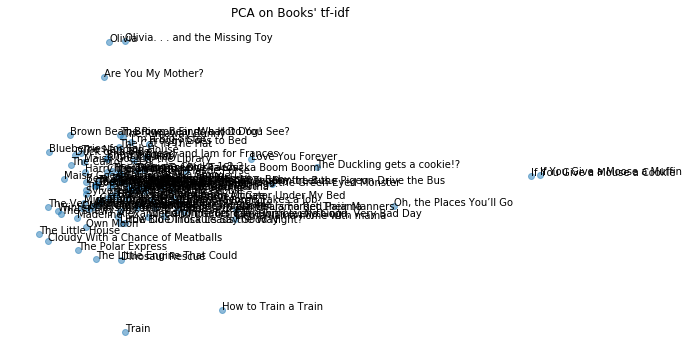

In [127]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 2], reduced_data[:, 3], alpha = 0.5)
for i, booktitle in enumerate(booktitles):
    ax.annotate(booktitle, (reduced_data[i,2], reduced_data[i,3]))
plt.xticks(())
plt.yticks(())
plt.title('PCA on Books\' tf-idf')
plt.show()

Based on above filtering, most books have similar tf-idf vectors except for a few. Upon closer inspection, these books appear to use idiosyncratic words frequently (e.g., George, Llama). I can try adding these to the stop words list to see how this changes the PCA.

In [96]:
new_stop_words = stop_words_freq[:] + ['george', 'llama']
#initialize
newbookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=.5, min_df=3, stop_words=new_stop_words, norm='l2')
#train
newbookgroupTFVects = newbookTFVectorizer.fit_transform(bookdf['text'])

In general – can tweak a few parameters w.r.t. tfidfvectorizer: max_df, min_df, stop_words.
Could also experiment with different stemming / lemmatization pre-processing.

In [129]:
newpca = PCA(n_components = 10).fit(newbookgroupTFVects.toarray())
newreduced_data = newpca.transform(newbookgroupTFVects.toarray())
components = newpca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
booktitles = bookdf['title']
#words = [terms[i] for i in keyword_ids]#Turn the ids into words.
#x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
#y = components[:,keyword_ids][1,:]

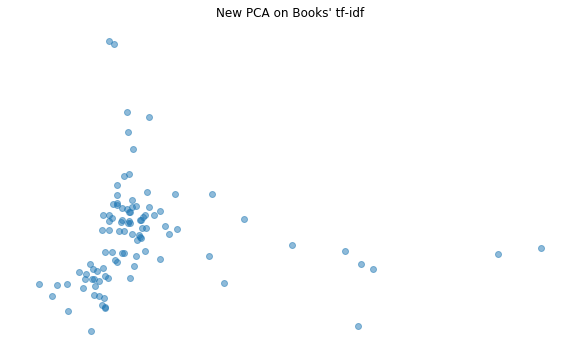

In [103]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(newreduced_data[:, 0], newreduced_data[:, 1], alpha = 0.5)
#for i, booktitle in enumerate(booktitles):
 #   ax.annotate(booktitle, (newreduced_data[i,0], newreduced_data[i,1]))
plt.xticks(())
plt.yticks(())
plt.title('New PCA on Books\' tf-idf')
plt.show()

Clustering algorithm:

In [111]:
numCategories = 3

In [112]:
bookKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
bookKM.fit(newbookgroupTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

This allows us to visualize the top 10 words per cluster:

In [128]:
terms = bookTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = bookKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 any
 eve
 along
 babushka
 become
 already
 across
 arrangement
 battered
 dearest


Cluster 1:
 elves
 due
 bumps
 claimed
 backward
 enters
 businesses
 dragon
 approached
 examine


Cluster 2:
 chopping
 choking
 ceilings
 charlie
 battered
 bumps
 bathtub
 counter
 expecting
 chops




Here we can reduce the tf-idf matrix using PCA in order to make visualization easier.

In [114]:
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in bookKM.labels_]

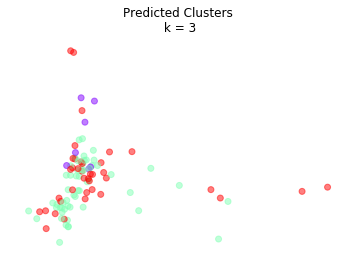

In [115]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(newreduced_data[:, 0], newreduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()